ValueError: in user code:

    File "/home/sigfred/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/sigfred/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sigfred/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/sigfred/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/sigfred/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/sigfred/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_8' (type Sequential).
    
    Input 0 of layer "conv3d_24" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 75, 46, 140, 3)
    
    Call arguments received by layer 'sequential_8' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 75, 46, 140, 3), dtype=float32)
      • training=False
      • mask=None


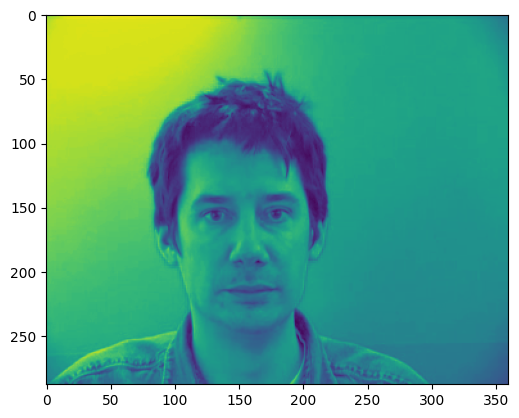

In [10]:
import tensorflow as tf
from typing import List
import cv2
import os 
import dlib
import ffmpeg
from matplotlib import pyplot as plt 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten


def load_model() -> Sequential: 
    model = Sequential()

    model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Dense(41, kernel_initializer='he_normal', activation='softmax'))

    model.load_weights('9models101/checkpoint')

    return model

def load_video(path:str) -> List[float]: 
    #print(path)
    pwd = os.getcwd()
    hog_face_detector = dlib.get_frontal_face_detector()

    dlib_facelandmark = dlib.shape_predictor(pwd + "/../data/shape_predictor_68_face_landmarks.dat")
    cap = cv2.VideoCapture(path)
    frames = []

    
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        gray2 = tf.image.rgb_to_grayscale(frame)
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = hog_face_detector(gray)

        #plt.imshow(gray2)

        face=faces[0]
        face_landmarks = dlib_facelandmark(gray, face)
     
                  
        #cv2.imshow('frames',frame)
        # start_point = ((face_landmarks.part(52).x) - 70, face_landmarks.part(52).y - 10)
        # end_point = ((face_landmarks.part(52).x) + 69, face_landmarks.part(52).y + 35)

        ytop=(face_landmarks.part(52).y)-10

        ybottom=(face_landmarks.part(52).y)+36

        xtop=(face_landmarks.part(52).x)-70

        xbottom=(face_landmarks.part(52).x)+70


        frames.append(frame[ytop:ybottom,xtop:xbottom,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std
    
    

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join(f'{file_name}.mpg')
    frames = load_video(video_path) 

    
    return frames

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
 # Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)



video= load_data(tf.convert_to_tensor(os.path.join('bbaf2n.mpg')))

#print(tf.expand_dims(video, axis=0).shape)

model = load_model()
yhat = model.predict(tf.expand_dims(video, axis=0))
decoder = tf.keras.backend.ctc_decode(yhat, [75], greedy=True)[0][0].numpy()


# Convert prediction to text
converted_prediction = tf.strings.reduce_join(num_to_char(decoder)).numpy().decode('utf-8')

print(converted_prediction)








In [4]:
import os
import cv2
import dlib

pwd = os.getcwd()

cap = cv2.VideoCapture(0)

hog_face_detector = dlib.get_frontal_face_detector()

dlib_facelandmark = dlib.shape_predictor(pwd + "/../data/shape_predictor_68_face_landmarks.dat")

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = hog_face_detector(gray)
    for face in faces:

        face_landmarks = dlib_facelandmark(gray, face)

        for n in range(0, 68):
            x = face_landmarks.part(n).x
            y = face_landmarks.part(n).y

        start_point = ((face_landmarks.part(50).x) - 100, face_landmarks.part(50).y - 30)
        end_point = ((face_landmarks.part(56).x) + 100, face_landmarks.part(56).y + 30)
        cv2.rectangle(frame, start_point, end_point, (0, 0, 255), 5)
        cv2.imwrite("frame%d.jpg" % 0, frame[190:236,80:220,:]) 

    cv2.imshow("Face Landmarks", frame)

    key = cv2.waitKey(1)
    if key == 27:
        break
cap.release()
cv2.destroyAllWindows()